In [1]:
import os

os.environ["BRASA_DATA_PATH"] = "D:\\brasa"

In [2]:
import sys
sys.path.append('..')

from datetime import datetime

import pandas as pd
import pyarrow.dataset as ds
import pyarrow.compute as pc
import pyarrow
from bizdays import Calendar, set_option

import brasa

man = brasa.engine.CacheManager()

In [3]:
set_option("mode.datetype", "datetime")
set_option("mode", "python")

cal = Calendar.load("ANBIMA")

In [4]:
db_folder_path = man.cache_path(man.db_folder())
tb_di1 = ds.dataset(f"{db_folder_path}\\b3-futures-di1\\", format="parquet").filter(pc.field("business_days") > 0).to_table()
tb_cdi = ds.dataset(f"{db_folder_path}\\bcb-data\\", format="parquet").filter(pc.field("symbol") == 'CDI').filter(pc.field("refdate").isin(tb_di1.column("refdate").unique().to_pylist())).to_table()

In [5]:
tb_v1 = (tb_cdi
            .set_column(1, "adjusted_tax", pc.divide(tb_cdi.column("value"), 100))
            .append_column("maturity_date", pyarrow.array(cal.offset(tb_cdi.column("refdate").to_pylist(), 1)))
            .append_column("business_days", pyarrow.array([1] * tb_cdi.shape[0]))
            .select(["refdate", "symbol", "maturity_date", "business_days", "adjusted_tax"]))

In [6]:
tb_di1_curve = pyarrow.concat_tables([
    tb_v1, tb_di1.select(["refdate", "symbol", "maturity_date", "business_days", "adjusted_tax"])
]).sort_by([("refdate", "ascending"), ("business_days", "ascending")])

In [7]:
ds.write_dataset(tb_di1_curve, os.path.join(db_folder_path, "b3-curves-di1"), format="parquet", existing_data_behavior="overwrite_or_ignore")

In [8]:
import numpy as np

def interp_ff(term, rates, terms):
    log_pu = np.log((1 + rates)**(terms/252))
    pu = np.exp(np.interp(term, terms, log_pu))
    return pu ** (252 / term) - 1

business_days_standard = np.array([21, 21 * 3, 21 * 6, 252, 252 * 5, 252 * 10, 252 * 20])
symbols_standard = pyarrow.array([f"DI1T{d}" for d in business_days_standard])
tables = []
for date in tb_di1_curve.column("refdate").unique():
    rates = tb_di1_curve.filter(pc.field("refdate") == date).column("adjusted_tax").to_numpy()
    terms = tb_di1_curve.filter(pc.field("refdate") == date).column("business_days").to_numpy()
    interp_rates = pyarrow.array(interp_ff(business_days_standard, rates, terms))
    mat_dates = pyarrow.array(cal.offset(date.as_py(), business_days_standard))
    ta = pyarrow.table([
        pyarrow.array([date.as_py()] * len(interp_rates)),
        symbols_standard,
        mat_dates,
        pyarrow.array(business_days_standard),
        interp_rates
    ], names=["refdate", "symbol", "maturity_date", "business_days", "adjusted_tax"])
    tables.append(ta)

In [9]:
tb_di1_curve_standard = pyarrow.concat_tables(tables).sort_by([("refdate", "ascending"), ("business_days", "ascending")])
ds.write_dataset(tb_di1_curve_standard, os.path.join(db_folder_path, "b3-curves-di1-standard"), format="parquet", existing_data_behavior="overwrite_or_ignore")

In [10]:
tables = []
for symbol in tb_di1_curve_standard.column("symbol").unique():
    rates = tb_di1_curve_standard.filter(pc.field("symbol") == symbol).column("adjusted_tax").to_numpy()
    dates = tb_di1_curve_standard.filter(pc.field("symbol") == symbol).column("refdate")
    symbols = tb_di1_curve_standard.filter(pc.field("symbol") == symbol).column("symbol")
    returns = np.concatenate([np.array([np.nan]), np.diff(rates)])
    ta = pyarrow.table([
        dates,
        symbols,
        pyarrow.array(returns)
    ], names=["refdate", "symbol", "returns"])
    tables.append(ta)

In [11]:
tb_di1_curve_standard_returns = pyarrow.concat_tables(tables).sort_by([("refdate", "ascending"), ("symbol", "ascending")])
ds.write_dataset(tb_di1_curve_standard_returns, os.path.join(db_folder_path, "b3-curves-di1-standard-returns"), format="parquet", existing_data_behavior="overwrite_or_ignore")

<Axes: xlabel='refdate'>

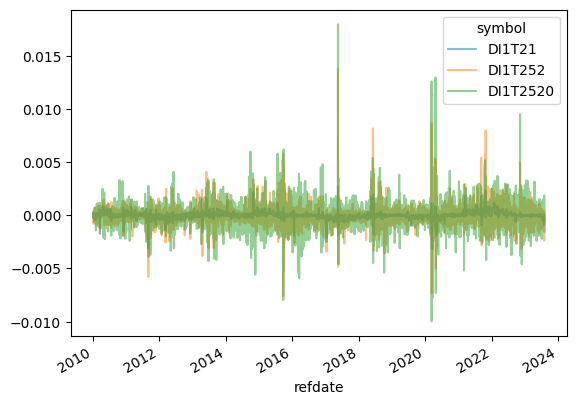

In [12]:
tb_di1_curve_standard_returns.filter(pc.field("symbol").isin(["DI1T21", "DI1T252", "DI1T2520"])).to_pandas().pivot_table(index="refdate", columns="symbol", values="returns").plot(alpha=0.5)